In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from os import listdir, getcwd
from os.path import isfile, join
from math import radians,sin

In [2]:
def great_circle_array(clon,clat,XLON,XLAT):
    """
    clon and clat are the target point (in degrees) to be compared to every point in XLON and XLAT
    XLON and XLAT should be the result of meshgrid meaning they are both 2D (in degrees)
    Out put is a 2D array of Great Circle Distances (GCD) from each point to the target point in meters
    """
    rearth = 6371000 #meters
    clon,clat = map(radians,[clon,clat])
    XLON,XLAT = map(np.radians,[XLON,XLAT])
    
    return rearth * ( np.arccos(sin(clat) * np.sin(XLAT) + np.cos(clat) * np.cos(XLAT) * np.cos(clon - XLON)) )

def great_circle_list(clon,clat,XLON,XLAT):
    """
    clon and clat are the target point (in degrees) to be compared to every point in XLON and XLAT
    XLON and XLAT should be the list of points that make up the front
    Out put is a list of Great Circle Distances (GCD) from each point to the target point in meters
    """
    rearth = 6371000 #meters
    clon,clat = map(radians,[clon,clat])
    XLON,XLAT = map(np.radians,[XLON,XLAT])
    
    return rearth * ( np.arccos(sin(clat) * np.sin(XLAT) + np.cos(clat) * np.cos(XLAT) * np.cos(clon - XLON)) )

def GCD_m2deg(GCD):
    rearth = 6371000 #meters
    return (GCD / (2*np.pi*rearth)) * 360

def GCD_deg2m(GCD):
    rearth = 6371000 #meters
    return (GCD / 360) * (2*np.pi*rearth)

def ExtractPlotData(frt):
    lats = []
    lons = []
    for co in frt[2:]:
        lats.append(co[0])
        lons.append(-1*co[1])
        
    if frt[0] == 'WARM':
        typ = 'red'
    elif frt[0] == 'STNRY':
        typ = 'green'
    elif frt[0] == 'COLD':
        typ = 'blue'
    elif frt[0] == 'OCFNT':
        typ = 'violet'
        
    return lons,lats,typ

# COMPUTES THE DISTANCE FROM A PEX TO THE END POINTS AND MID-POINT OF EACH FRONTAL SEGMENT AND RETURNS THE MINIMUM DISTANCE IN GREAT CIRCLE DEGREES
def GCD_Point2Front_AtTime(clon,clat,frts):
    mindist = []
    for frt in frts:
        lons,lats,_ = ExtractPlotData(frt)
        gcds = GCD_m2deg(great_circle_list(clon,clat,np.array(lons),np.array(lats)))
        mindist.append(np.min(gcds))
        # WHAT IF WE ALSO CHECK THE MID POINTS
        mlons = []
        mlats = []
        for gg in range(len(lons)-1):
            mlons.append((lons[gg]+lons[gg+1])/2)
            mlats.append((lats[gg]+lats[gg+1])/2)
        gcds = GCD_m2deg(great_circle_list(clon,clat,np.array(mlons),np.array(mlats)))
        mindist.append(np.min(gcds))
        
    return min(mindist)

In [3]:
file_number = 70

path = 'WPC_CODSUS/lores/2003'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
onlyfiles.sort()

with open(path+'/'+onlyfiles[file_number]) as f:
    lines = f.readlines()
f.close()

# lines

In [4]:
FRONT_coords = []
number = 0
while number < len(lines):
    if len(lines[number])==1:
        number+=1
    elif lines[number].split()[0] in ['WARM','STNRY','COLD','OCFNT']:
        coordlist = [lines[number].split()[0],lines[number].split()[1]]
        if lines[number+1][0].isdigit():
            front_data = lines[number].split() + lines[number+1].split()
            number+=1
        else:
            front_data = lines[number].split()
        for coords in front_data[2:]:
            coordlist.append([int(coords[:2]),int(coords[2:])])
        FRONT_coords.append(coordlist)
        number+=1
    else:
        number+=1

In [5]:
print(onlyfiles[file_number])
year = onlyfiles[file_number][11:15]
month = onlyfiles[file_number][15:17]
day = onlyfiles[file_number][17:19]
hour = onlyfiles[file_number][20:22]

KWBCCODSUS_20030112_0900


In [6]:
frt_dat = xr.open_dataset('./gradEPT_Frontal_percentile-buffer.nc')
frt_day = frt_dat.gradEPT_percentile_AboveMedian_Buffer3x3x3.sel(time=year+'-'+month+'-'+day+'-'+hour)
fd2 = frt_dat.gradEPT_percentile_AboveMedian.sel(time=year+'-'+month+'-'+day+'-'+hour)

In [7]:
pcip = xr.open_dataset('../Data/ERA5_'+year+'_tp_3H.nc')
tp = pcip.tp.sel(time=year+'-'+month+'-'+day+'-'+hour)

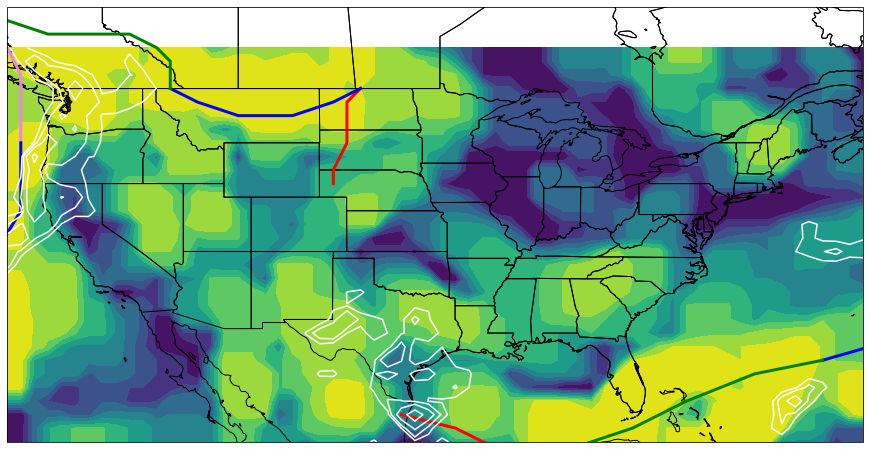

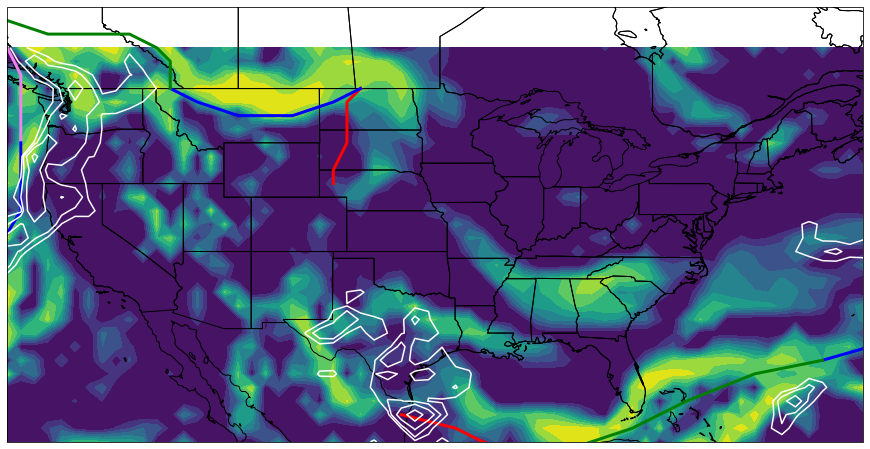

In [21]:
proj = ccrs.PlateCarree()
MyFigure = plt.figure(figsize = (16,8))
ax = MyFigure.add_subplot(1,1,1,projection=proj)
ax.set_extent([-127, -64, 23, 55], crs=proj)
for frt in FRONT_coords:
    [lons,lats,typ] = ExtractPlotData(frt)
    ax.plot(lons,lats,color = typ,linewidth=3)
c=ax.contourf(frt_dat['longitude'],frt_dat['latitude'],frt_day,levels=np.linspace(0,100,11))
ax.contour(tp['longitude'],tp['latitude'],tp*1000,levels=[1,2,4,8],colors='white')
# plt.colorbar(c,orientation='horizontal')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

proj = ccrs.PlateCarree()
MyFigure = plt.figure(figsize = (16,8))
ax = MyFigure.add_subplot(1,1,1,projection=proj)
ax.set_extent([-127, -64, 23, 55], crs=proj)
for frt in FRONT_coords:
    [lons,lats,typ] = ExtractPlotData(frt)
    ax.plot(lons,lats,color = typ,linewidth=3)
c=ax.contourf(frt_dat['longitude'],frt_dat['latitude'],fd2,levels=np.linspace(0,100,11))
ax.contour(tp['longitude'],tp['latitude'],tp*1000,levels=[1,2,4,8],colors='white')
# plt.colorbar(c,orientation='horizontal')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

In [16]:
np.arange(0,100,10)

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])